Based on this report https://docs.google.com/document/d/1ooqYAR5jk_Ngk12R-0StoeLuAPb9f4gNJxush57IY2Y/edit?tab=t.0 we are going to use a 2-layer MMLP with LeakyReLU to perform multi-label claasficiation of the Roboflow RPS dataset.

Feeding the MLP with the entire image is not optimal and training is slow, so we will use the bounding boxes to crop the images before performing classification.
This time we will classify the images into one of the classes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import numpy as np
from torchvision import transforms, models
import tqdm
from PIL import Image

In [2]:
class RoboflowRPSDataset(Dataset):
    def __init__(self, images_dir, labels_dir, crop_size=64, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.crop_size = crop_size
        self.transform = transform

        self.classes = {0: 'rock', 1: 'paper', 2: 'scissors', 3: 'null'}
        self.class_to_idx = {v: k for k, v in self.classes.items()}

        self.samples = []  # List of (cropped_hand_image, label)

        self._load_samples()

    def _load_samples(self):
        image_files = [f for f in os.listdir(self.images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            image_path = os.path.join(self.images_dir, image_file)
            label_path = os.path.join(self.labels_dir, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))

            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape

            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                with open(label_path, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(parts[0])
                            x_center = float(parts[1]) * w
                            y_center = float(parts[2]) * h
                            width = float(parts[3]) * w
                            height = float(parts[4]) * h

                            x1 = max(0, int(x_center - width / 2))
                            y1 = max(0, int(y_center - height / 2))
                            x2 = min(w, int(x_center + width / 2))
                            y2 = min(h, int(y_center + height / 2))

                            hand_crop = image[y1:y2, x1:x2]
                            hand_crop = cv2.resize(hand_crop, (self.crop_size, self.crop_size))
                            hand_pil = Image.fromarray(hand_crop)
                            self.samples.append((hand_pil, class_id))
            else:
                # No hands = negative sample
                # Use full image (optional) or center crop or dummy blank
                # Here: center crop to keep it consistent
                center_crop = self._center_crop(image, size=self.crop_size)
                crop_pil = Image.fromarray(center_crop)
                self.samples.append((crop_pil, 3))  # class_id 3 = 'null'

    def _center_crop(self, img, size):
        h, w, _ = img.shape
        center_x, center_y = w // 2, h // 2
        half_size = size // 2
        x1 = max(0, center_x - half_size)
        y1 = max(0, center_y - half_size)
        x2 = min(w, center_x + half_size)
        y2 = min(h, center_y + half_size)
        cropped = img[y1:y2, x1:x2]
        return cv2.resize(cropped, (size, size))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img, label = self.samples[idx]
        if self.transform:
            img = self.transform(img)
        else:
            # Default: ToTensor and normalize to [0, 1]
            img = transforms.ToTensor()(img)
        return img.view(-1), label  # Flattened input for MLP

MLP

In [3]:
class RPSModel(nn.Module):
    def __init__(self, activation_func: str = "leakyrelu", input_size=0, num_classes=4):
        super().__init__()
        
        activation = self.get_activation(activation_func)

        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            activation,
            nn.Linear(256, 64),
            activation,
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

    def get_activation(self, name):
        name = name.lower()
        if name == "relu":
            return nn.ReLU()
        elif name == "tanh":
            return nn.Tanh()
        elif name == "sigmoid":
            return nn.Sigmoid()
        elif name == "leakyrelu":
            return nn.LeakyReLU()
        elif name == "gelu":
            return nn.GELU()
        else:
            raise ValueError(f"Unsupported activation function: {name}")


In [ ]:
# Simple transforms for MLP (no need for pretrained normalization)
IMG_SIZE = 64
EPOCHS = 35

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset and loader
dataset_path = "../rock-paper-scissors-11"
train_dataset = RoboflowRPSDataset(
    images_dir=f'{dataset_path}/train/images',
    labels_dir=f'{dataset_path}/train/labels',
    crop_size=IMG_SIZE,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = RoboflowRPSDataset(
    images_dir=f'{dataset_path}/test/images',
    labels_dir=f'{dataset_path}/test/labels',
    crop_size=IMG_SIZE,
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = RoboflowRPSDataset(
    images_dir=f'{dataset_path}/valid/images',
    labels_dir=f'{dataset_path}/valid/labels',
    crop_size=IMG_SIZE,
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, train_loader, optimizer, criterion, device):

    # Training loop
    model.train()
    #for epoch in range(EPOCHS):
    if True:
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        all_preds, all_labels = [], []

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)

            # Multi-label loss
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)

            predictions = logits.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.numel()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions

        # print(f'Epoch [{epoch+1}/20]')
        print(f'Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
        print('-' * 50)

    return all_preds, all_labels, accuracy


def test(model, test_loader, device):

    # device = next(model.parameters()).device
    # test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)  # shape: [B, 4]
            preds = outputs.argmax(dim=1)  # predicted class index
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    correct_predictions = (np.array(all_preds) == np.array(all_labels)).sum().item()
    total_predictions = len(all_labels)
    acc = correct_predictions / total_predictions
    
    return all_preds, all_labels, acc


In [26]:
model = RPSModel(
    input_size=IMG_SIZE*IMG_SIZE*3,  # Flattened image size
    # hidden_size=512,       # Hidden layer size
    num_classes=4          # rock, paper, scissors, null
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
res = {i: None for i in range(EPOCHS)}

train_acc_list = []
val_acc_list = []

for epoch in range(5):
    all_preds_train, all_labels_train, val_accuracy = train(model, train_loader, optimizer, criterion, device)    
    all_preds, all_labels, test_accuracy = test(model, val_loader, device)
    print(f"Epoch {epoch+1}/{EPOCHS} completed. Train Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    print(len(all_preds_train), len(all_labels_train), len(all_preds), len(all_labels))
    train_acc_list.append(val_accuracy)
    val_acc_list.append(test_accuracy)
    
    res[epoch] = {
        'epoch': epoch + 1,
        'train_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'train_preds': all_preds_train,
        'train_labels': all_labels_train,
        'test_preds': all_preds,
        'test_labels': all_labels
    }

Average Loss: 80.6897, Accuracy: 0.4567
--------------------------------------------------
Epoch 1/35 completed. Train Accuracy: 0.4567, Test Accuracy: 0.5727
16520 16520 653 653
Average Loss: 66.3675, Accuracy: 0.5748
--------------------------------------------------
Epoch 2/35 completed. Train Accuracy: 0.5748, Test Accuracy: 0.5942
16520 16520 653 653
Average Loss: 60.3882, Accuracy: 0.6150
--------------------------------------------------
Epoch 3/35 completed. Train Accuracy: 0.6150, Test Accuracy: 0.6217
16520 16520 653 653
Average Loss: 56.2447, Accuracy: 0.6424
--------------------------------------------------
Epoch 4/35 completed. Train Accuracy: 0.6424, Test Accuracy: 0.5681
16520 16520 653 653
Average Loss: 53.6364, Accuracy: 0.6602
--------------------------------------------------
Epoch 5/35 completed. Train Accuracy: 0.6602, Test Accuracy: 0.6554
16520 16520 653 653


In [27]:
# Compute detailed metrics (same as before)
def compute_metrics(all_predictions, all_labels):
    """Compute comprehensive metrics for multi-label classification"""
    import numpy as np
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

    classes = ['rock', 'paper', 'scissors', 'null']
    n_classes = len(classes)

    # Convert lists of class indices to one-hot encoded numpy arrays
    all_labels_arr = np.array(all_labels)
    all_predictions_arr = np.array(all_predictions)
    all_labels_onehot = np.eye(n_classes)[all_labels_arr]
    all_predictions_onehot = np.eye(n_classes)[all_predictions_arr]

    print("=" * 60)
    print("MULTI-LABEL CLASSIFICATION RESULTS")
    print("=" * 60)

    # Overall metrics (exact match accuracy)
    exact_match_accuracy = accuracy_score(all_labels_arr, all_predictions_arr)
    print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")

    # Per-class metrics
    print("\nPer-Class Metrics:")
    print("-" * 40)

    for i, class_name in enumerate(classes):
        precision = precision_score(all_labels_onehot[:, i], all_predictions_onehot[:, i], zero_division=0)
        recall = recall_score(all_labels_onehot[:, i], all_predictions_onehot[:, i], zero_division=0)
        f1 = f1_score(all_labels_onehot[:, i], all_predictions_onehot[:, i], zero_division=0)

        print(f"{class_name:>10}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

    # Macro and micro averages
    macro_f1 = f1_score(all_labels_onehot, all_predictions_onehot, average='macro', zero_division=0)
    micro_f1 = f1_score(all_labels_onehot, all_predictions_onehot, average='micro', zero_division=0)

    print(f"\nMacro F1-Score: {macro_f1:.4f}")
    print(f"Micro F1-Score: {micro_f1:.4f}")

    # Detailed classification report
    print("\nDetailed Classification Report:")
    print("-" * 40)
    report = classification_report(all_labels_onehot, all_predictions_onehot, target_names=classes, zero_division=0)
    print(report)

    return {
        'exact_match_accuracy': exact_match_accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    }

# Analyze some examples (same as before)
def analyze_examples(results, num_examples=10):
    """Show some example predictions"""
    print("\n" + "=" * 60)
    print("EXAMPLE PREDICTIONS")
    print("=" * 60)
    
    # Show correct predictions
    correct_examples = [r for r in results if r['correct']][:num_examples//2]
    print(f"\n✅ CORRECT PREDICTIONS ({len(correct_examples)} shown):")
    for example in correct_examples:
        print(f"Image: {example['image_file']}")
        print(f"True: {example['true_labels']}")
        print(f"Pred: {example['predicted_labels']}")
        print(f"Probs: {example['probabilities']}")
        print("-" * 30)
    
    # Show incorrect predictions
    incorrect_examples = [r for r in results if not r['correct']][:num_examples//2]
    print(f"\n❌ INCORRECT PREDICTIONS ({len(incorrect_examples)} shown):")
    for example in incorrect_examples:
        print(f"Image: {example['image_file']}")
        print(f"True: {example['true_labels']}")
        print(f"Pred: {example['predicted_labels']}")
        print(f"Probs: {example['probabilities']}")
        print("-" * 30)

all_predictions, all_labels, test_accuracy = test(model, test_loader, device)
print(len(all_predictions), len(all_labels), test_accuracy)
metrics = compute_metrics(all_predictions, all_labels)

# Analyze examples
# analyze_examples(results)

if False:
    # Summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)
    # total_images = len(results)
    total_images = len(all_labels)
    correct_predictions = sum(1 for r in results if r['correct'])
    accuracy = correct_predictions / total_predictions

    print(f"Total test images: {total_images}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Overall accuracy: {accuracy:.4f}")

    # Class distribution in test set
    _, class_counts = np.unique(all_labels, return_counts=True)
    classes = list(test_dataset.classes.values())
    print(f"\nClass distribution in test set:")
    for i, class_name in enumerate(classes):
        print(f"{class_name}: {int(class_counts[i])} images")

    # Additional analysis: confusion matrix per class
    print(f"\nConfusion Matrix Analysis:")
    print("-" * 40)

    for i, class_name in enumerate(classes):
        # True Positive: predicted i and actually i
        tp = np.sum((all_predictions == i) & (all_labels == i))
        
        # False Positive: predicted i but actually something else
        fp = np.sum((all_predictions == i) & (all_labels != i))
        
        # False Negative: predicted something else but actually i
        fn = np.sum((all_predictions != i) & (all_labels == i))
        
        # True Negative: predicted not i and actually not i
        tn = np.sum((all_predictions != i) & (all_labels != i))
        print(f"\n{class_name}:")
        print(f"  TP: {tp}, FP: {fp}")
        print(f"  FN: {fn}, TN: {tn}")

342 342 0.6695906432748538
MULTI-LABEL CLASSIFICATION RESULTS
Exact Match Accuracy: 0.6696

Per-Class Metrics:
----------------------------------------
      rock: Precision=0.6579, Recall=0.3472, F1=0.4545
     paper: Precision=0.7164, Recall=0.6667, F1=0.6906
  scissors: Precision=0.5577, Recall=0.4394, F1=0.4915
      null: Precision=0.6865, Recall=0.9621, F1=0.8013

Macro F1-Score: 0.6095
Micro F1-Score: 0.6696

Detailed Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        rock       0.66      0.35      0.45        72
       paper       0.72      0.67      0.69        72
    scissors       0.56      0.44      0.49        66
        null       0.69      0.96      0.80       132

   micro avg       0.67      0.67      0.67       342
   macro avg       0.65      0.60      0.61       342
weighted avg       0.66      0.67      0.65       342
 samples avg       0.67      0.67      0.67       342



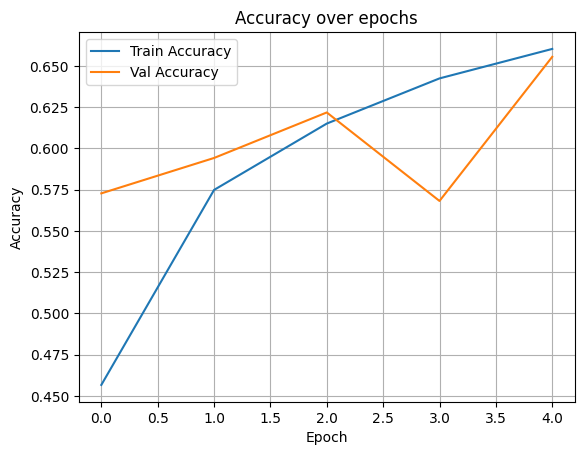

In [28]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.grid(True)
plt.show()


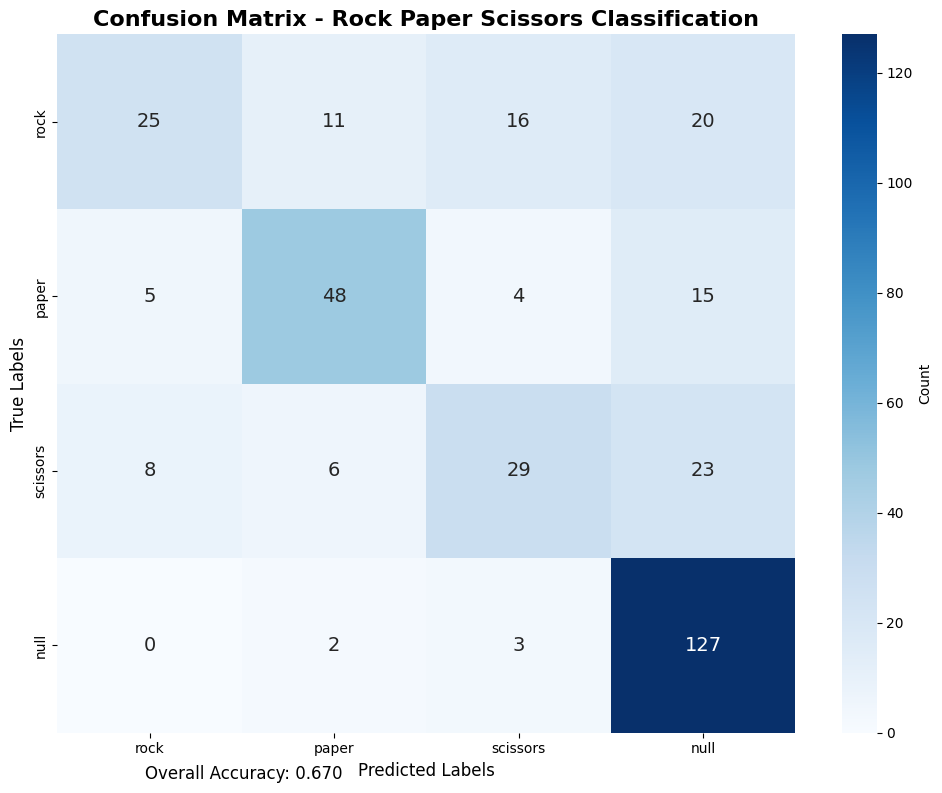

Confusion Matrix Analysis:
Class      TP     FP     FN     TN     Precision  Recall  
--------------------------------------------------
rock       25     13     47     257    0.658      0.347   
paper      48     19     24     251    0.716      0.667   
scissors   29     23     37     253    0.558      0.439   
null       127    58     5      152    0.686      0.962   


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(all_predictions, all_labels, classes=['rock', 'paper', 'scissors', 'null']):
    """Plot confusion matrix for multi-class classification"""
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot heatmap
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=classes,
                yticklabels=classes,
                cbar_kws={'label': 'Count'},
                annot_kws={"size": FONT_SIZE})
    
    plt.title('Confusion Matrix - Rock Paper Scissors Classification', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    
    # Add accuracy information
    accuracy = np.trace(cm) / np.sum(cm)
    plt.figtext(0.15, 0.02, f'Overall Accuracy: {accuracy:.3f}', fontsize=12, ha='left')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("Confusion Matrix Analysis:")
    print("=" * 50)
    print(f"{'Class':<10} {'TP':<6} {'FP':<6} {'FN':<6} {'TN':<6} {'Precision':<10} {'Recall':<8}")
    print("-" * 50)
    
    for i, class_name in enumerate(classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"{class_name:<10} {tp:<6} {fp:<6} {fn:<6} {tn:<6} {precision:<10.3f} {recall:<8.3f}")
    
    return cm

# Ensure both lists are the same length and correspond to the test set
assert len(all_predictions) == len(all_labels), f"all_predictions ({len(all_predictions)}) and all_labels ({len(all_labels)}) must have the same length"

# Plot the confusion matrix
cm = plot_confusion_matrix(all_predictions, all_labels)


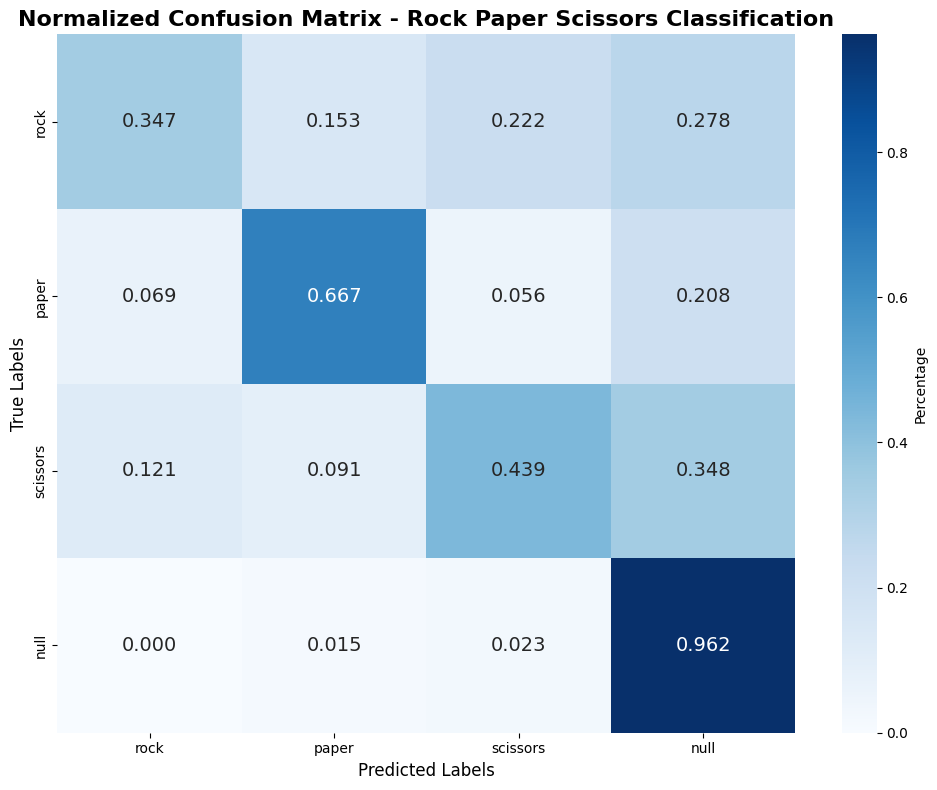

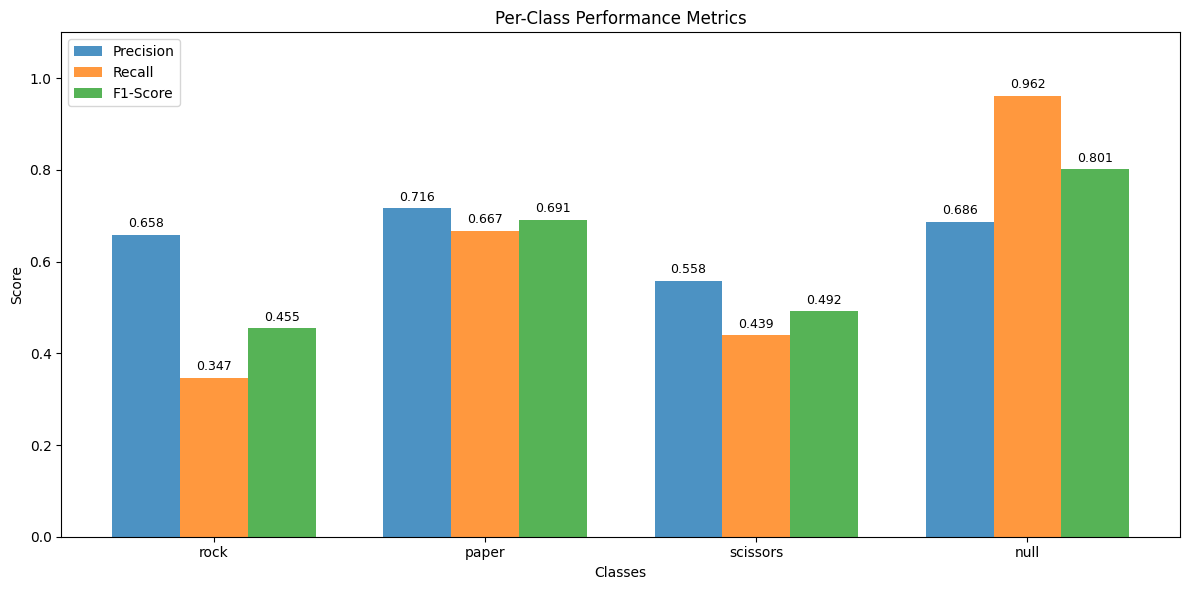

In [32]:
FONT_SIZE = 14 

# Additional visualization: Normalized confusion matrix
def plot_normalized_confusion_matrix(all_predictions, all_labels, classes=['rock', 'paper', 'scissors', 'null']):
    """Plot normalized confusion matrix (percentages)"""
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    
    # Plot normalized heatmap
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.3f', 
                cmap='Blues',
                xticklabels=classes,
                yticklabels=classes,
                cbar_kws={'label': 'Percentage'},
                annot_kws={"size": FONT_SIZE})
    
    plt.title('Normalized Confusion Matrix - Rock Paper Scissors Classification', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return cm_normalized

# Plot normalized confusion matrix
cm_norm = plot_normalized_confusion_matrix(all_predictions, all_labels)

# Class-wise performance visualization
def plot_class_performance(all_predictions, all_labels, classes=['rock', 'paper', 'scissors', 'null']):
    """Plot per-class performance metrics"""
    
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    # Convert to one-hot for per-class metrics
    n_classes = len(classes)
    all_labels_arr = np.array(all_labels)
    all_predictions_arr = np.array(all_predictions)
    all_labels_onehot = np.eye(n_classes)[all_labels_arr]
    all_predictions_onehot = np.eye(n_classes)[all_predictions_arr]
    
    # Calculate metrics
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(n_classes):
        precision = precision_score(all_labels_onehot[:, i], all_predictions_onehot[:, i], zero_division=0)
        recall = recall_score(all_labels_onehot[:, i], all_predictions_onehot[:, i], zero_division=0)
        f1 = f1_score(all_labels_onehot[:, i], all_predictions_onehot[:, i], zero_division=0)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Create bar plot
    x = np.arange(len(classes))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars1 = ax.bar(x - width, precisions, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recalls, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    plt.tight_layout()
    plt.show()

# Plot class performance
plot_class_performance(all_predictions, all_labels)